# Предсказание траекторий автомобилей

In [1]:
#!c1.8
from IPython.display import Video

Video("motion-prediction-video.mp4", width=400, height=400)

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')

## Датасет

Для работы над проектом возьмем некоторое подмножество датасета [Shifts](https://research.yandex.com/shifts) из трека про предсказание движения автомобилей.

Датасет представляет собой набор сцен. Каждая сцена содержит в себе информацию о динамических объектах (автомобилях,  пешеходах и самом беспилотнике), карту дорожного полотна и состояния светофоров. Длительность каждой сцены составляет 10 секунд: 5 секунд прошлого и 5 секунд будущего. Таким образом, задача - зная прошлую информацию об окружающем мире, научиться предсказывать будущее его состояние.

Для каждого автомобиля в сцене известны следующие параметры:
- уникальный идентификатор
- положение в глобальной системе координат (x и y)
- размеры (длина и ширина)
- линейная скорость (вдоль осей x и y)
- линейное ускорение (вдоль осей x и y)
- направление вдоль оси z (угол в радианах)

Аналогичные данные известны для самого беспилотника. Для пешехедов данные ограничиваются id, положением, размером и скоростью.

Дорожный граф (карта) содержит в себе информацию о полосах, полигон дороги, полигоны пешеходных переходов.

## Ссылки на данные

Train: https://disk.yandex.ru/d/tuTwRSLL-KFqjg

Validation: https://disk.yandex.ru/d/3Lu6_6BgwkXlgw

Test: https://disk.yandex.ru/d/M_4ED0r19OnSrg

Данные лежат в tar-архивах. Их можно распаковать командой ```tar -xzf train.tar.gz```

## Python API датасета

Для работы с датасетом нам понадобится установить python пакет.

Следующием команды нужно выполнить в консоли (или напрямую из ячеек ноутбука, начиная каждую команду с ```!```, например ```!python3 ...```):
```
python3 -m venv .my_venv
source .my_venv/bin/activate
git clone https://github.com/Shifts-Project/shifts.git
cd shifts/sdc
pip install .
```

## Структура проекта

Проект будет состоять из нескольких этапов.

**Этап 0.** Посмотрим на возможные представления данных. Придумаем, какими метриками можно оценивать модели в нашей задаче. Реализуем бейзлайновую модель, которую нам необходимо будет побить, и нарисуем её предсказания.

**Этап 1.** На этом шаге мы используем наши знания о полносвязных нейросетях и векторное преставление сцены, чтобы реализовать первую модель.

**Этап 2.** Применим сверточные нейросети к картиночному представлению сцены.

## Этап 0

### Представление сцены

Основные классы для взаимодействия датасетом:
- ```FeatureVectorizer``` - достает из сцены описание объекта, для которого мы делаем предсказание в векторном виде
- ```MotionPredictionDataset``` - испольуя классы выше, реализует Pytorch-style датасет

Класс ```FeatureVectorizer``` можно настраивать с помощью словарей с конфигурацией. Это позволяет задавать интересующую нас глубину истории и набор признаков. Подробнее мы посмотрим дальше.

In [ ]:
#!c1.8
import json
import yaml

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections as mc

from ysdc_dataset_api.dataset import TFMotionPredictionDataset
from ysdc_dataset_api.features import FeatureRenderer, FeatureVectorizer
from ysdc_dataset_api.utils import transform_2d_points

/home/jupyter/.local/lib/python3.8/site-packages/ysdc_dataset_api/utils/transform.py:90: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, C))
  res = transform @ ph
/usr/local/lib/python3.8/dist-packages/numba/core/typing/npydecl.py:930: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, C))
  warnings.warn(NumbaPerformanceWarning(msg))


In [ ]:
#!c1.8
with open('vectorizer_config.yaml') as f:
    vectorizer_config = yaml.safe_load(f)

In [ ]:
#!c1.8
print(json.dumps(vectorizer_config, indent=2))

{
  "time_grid_params": {
    "start": 0,
    "stop": 4,
    "step": 1
  },
  "features": [
    "position",
    "velocity",
    "acceleration",
    "yaw"
  ]
}


Конфиг векторайзера содержит поля `time_grid_params` и `features`.

Первое отвечает за количество исторических моментов времени, извлекаемых из сцены для объекта. Параметр `start=0` соответсвует последнему известному состоянию автомобиля. `stop=4` отсчитывает 4 таймстемпа назад, что с шагом `step=1`, даёт нам 5 моментов времени. Максимальная глубина истории 25, что будет соответсвовать параметрам `start=0, stop=24, step=1`.

Поле `features` отвечает за то, какие признаки мы хотим извлечь из сцены для дальшейшего использования. `position` даёт нам x и y координаты (2 признака), `velocity` - линейную скорость по x и y (2 признака), `acceleration` - линейное ускорение по x и y (2 признака), `yaw` - угол (1 признак). Итого 7 признаков для каждого из 5 моментов времени в прошлом.

In [ ]:
#!c1.8
# Создадим векторайзер
vectorizer = FeatureVectorizer(vectorizer_config)

Как было упомянуто выше, информацию из сцены так же можно представить в виде изображения. Рендеринг работает довоьлно долго, и делать его налету в процессе обучения будет проблематично. Поэтому мы воспользуемся уже готовыми многоканальными изображениями, которые приложены к датасету.

In [ ]:
#!c1.8
dataset_path = 'data/train'
val_dataset_path = 'data/val'
test_dataset_path = 'data/test'

dataset = TFMotionPredictionDataset(
    # Путь к датасету
    dataset_path=dataset_path,
    # Путь к подготовленным картинкам, у нас они лежат там же
    prerendered_dataset_path=dataset_path,
    # Набор объектов, умеющих готовить фичи для модели. У нас это только векторайзер.
    feature_producers=[vectorizer],
).get_tf_dataset()

val_dataset = TFMotionPredictionDataset(
    dataset_path=val_dataset_path,
    prerendered_dataset_path=val_dataset_path,
    feature_producers=[vectorizer],
).get_tf_dataset()

test_dataset = TFMotionPredictionDataset(
    dataset_path=test_dataset_path,
    prerendered_dataset_path=test_dataset_path,
    feature_producers=[vectorizer],
).get_tf_dataset()

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dataset, test_dataset, val_dataset
  warnings.warn(message)


In [ ]:
#!c1.8
# Посмотрим, что лежит в одном объекте из датасета
data_item = next(iter(dataset))
print(data_item.keys())

dict_keys(['ground_truth_trajectory', 'scene_id', 'track_id', 'prerendered_feature_map', 'vector_features'])


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dataset, test_dataset, val_dataset
  warnings.warn(message)


Нас интересуют следующие поля:
- `ground_truth_trajectory` - траектория, которую нам надо предсказать,
- `prerendered_feature_map` - подготовленное изображение сцены вокруг автомобиля,
- `vector_features` - векторное представление целевого автомобиля.

In [ ]:
#!c1.8
print(data_item['ground_truth_trajectory'].shape)

(25, 2)


In [ ]:
#!c1.8
print(data_item['ground_truth_trajectory'])

tf.Tensor(
[[ 9.8083496e-02 -1.6210556e-02]
 [-2.1453857e-02 -5.9974670e-02]
 [-1.3870239e-01 -7.1348190e-02]
 [-1.5197754e-01 -3.2289505e-02]
 [ 6.1065674e-02 -8.0108643e-05]
 [ 1.8051147e-01 -2.4965286e-02]
 [ 2.3358154e-01 -3.1501770e-02]
 [ 2.3767090e-01 -4.7439575e-02]
 [ 2.6086426e-01 -3.4521103e-02]
 [ 2.2857666e-01 -4.7407150e-02]
 [ 2.4829102e-01 -1.7486572e-02]
 [ 2.2973633e-01 -2.9182434e-02]
 [ 3.3026123e-01 -7.1620941e-03]
 [ 3.2449341e-01  1.0303497e-02]
 [ 3.1008911e-01  9.8934174e-03]
 [ 3.5311890e-01 -3.6144257e-03]
 [ 3.8018799e-01 -2.5259018e-02]
 [ 4.2044067e-01 -5.0052643e-02]
 [ 2.9519653e-01 -1.4421463e-02]
 [ 3.7106323e-01 -1.1652374e-01]
 [ 4.3930054e-01 -1.1513138e-01]
 [ 4.2144775e-01 -8.1237793e-02]
 [ 3.6071777e-01 -2.4038315e-02]
 [ 4.4265747e-01 -7.6370239e-02]
 [ 4.8245239e-01 -1.2498093e-01]], shape=(25, 2), dtype=float32)


Предсказываемая траектория имеет размерность (25, 2), где 25 - количество моментов в будущем, на которые мы ххотим сделать предказание, а 2 - x и y координаты в метрах, где автомобиль окажется в эти моменты.

In [ ]:
#!c1.8
print(data_item['vector_features'].shape)

(5, 8)


In [ ]:
#!c1.8
print(data_item['vector_features'])

tf.Tensor(
[[-0.19607544  0.0065918   0.          0.          0.          0.
   1.3975863   1.        ]
 [-0.17193604  0.00763702  0.          0.          0.          0.
   1.394321    1.        ]
 [-0.17208862  0.00679779  0.          0.          0.          0.
   1.376034    1.        ]
 [-0.17404175  0.00531006  0.          0.          0.          0.
   1.3643332   1.        ]
 [ 0.          0.          0.5979004  -0.00255394  0.49191284  0.14166641
   1.3696145   1.        ]], shape=(5, 8), dtype=float32)


Векторное представление имеет размерность (5, 8), где 5 - количество исторических моментов (которое мы указали в конфиге), 8 - размерность признаков. Признаков на один больше, чем было указано выше. Векторайзер добавляет один неявно добавляет один признак, указывающий были ли данные известны на этот момент в истории (1) или были заполнены нулями (0).

In [ ]:
#!c1.8
print(data_item['prerendered_feature_map'].shape)

(17, 128, 128)


Размерность изображения (17, 128, 128). Изображения представляют собой вид сверху, при этом в центре всегда находится автомобиль, для которого мы делаем предсказание. Каналы содержат информацию о положении автомобилей и пешеходов, их скорости и ускорения, дорожну карту. Более подробное описание доступно в файле `renderer_config.yaml`.

In [ ]:
#!c1.8
# Создадим рендерер. Нам он понадобится только для визуализации.
with open('renderer_config.yaml') as f:
    renderer_config = yaml.safe_load(f)
renderer = FeatureRenderer(renderer_config)

In [ ]:
#!c1.8
def draw_feature_map(feature_map, gt_trajectory=None, pred_trajectory=None, *, transform=None):
    # Plot vehicles occupancy, pedestrian occupancy, lane occupancy and road polygon
    plt.figure(figsize=(10, 10))
    # 0 канал -- положение автомобилей
    plt.imshow(feature_map[0], origin='lower', cmap='binary', alpha=0.7)
    # 6 канал -- положение пешеходов
    plt.imshow(feature_map[6], origin='lower', cmap='binary', alpha=0.5)
    # 13 канал -- положение дорожных полос
    plt.imshow(feature_map[13], origin='lower', cmap='binary', alpha=0.2)
    # 16 канал -- полигон дороги
    plt.imshow(feature_map[16], origin='lower', cmap='binary', alpha=0.1)

    if gt_trajectory is not None:
        assert transform is not None
        # Переведем ground truth траекторию агента в систему координат фичемапы
        gt_trajectory = np.concatenate(
            (np.array([[0, 0]], dtype=np.float32), gt_trajectory),
            axis=0)
        transformed_gt = transform_2d_points(gt_trajectory, transform)
        ax = plt.gca()
        ax.add_collection(mc.LineCollection([transformed_gt], color='green'))

    if pred_trajectory is not None:
        assert transform is not None
        prediction = np.concatenate(
            (np.array([[0, 0]], dtype=np.float32), pred_trajectory),
            axis=0)
        transformed_prediction = transform_2d_points(prediction, renderer.to_feature_map_tf)
        ax.add_collection(mc.LineCollection([transformed_prediction], color='red'))

In [ ]:
#!c1.8
# Поищем пример, где смещение по оси x было больше 5 метров в финальной точке.
dataset_iter = iter(dataset)
while True:
    data_item = next(dataset_iter)
    if data_item['ground_truth_trajectory'][-1, 0] > 5:
        break

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dataset, dataset_iter, test_dataset, val_dataset
  warnings.warn(message)


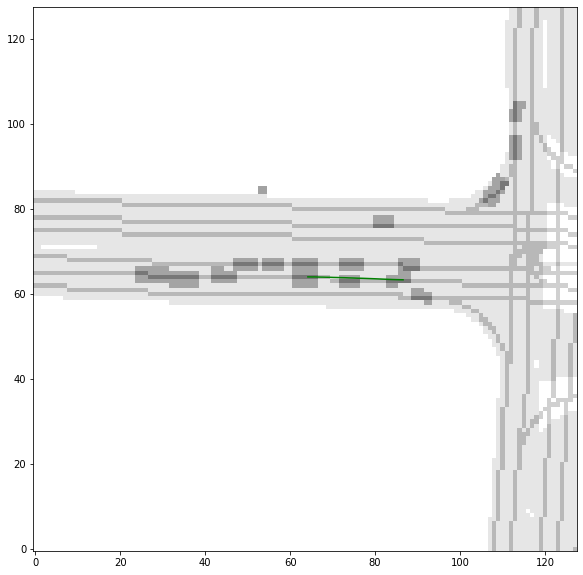

In [ ]:
#!c1.8
draw_feature_map(
    data_item['prerendered_feature_map'],
    data_item['ground_truth_trajectory'],
    transform=renderer.to_feature_map_tf,
)

На изображении мы видим коробочки автомобилей, дорожную карту, а так же будущую траекторию автомобиля зеленым цветом.

### Метрики

Одними из общепринятых метрик для оценки качества предсказания траекторий являются Average Displacement Error и Final Displacement Error, а так же их модификации minADE@k, minFDE@k для случая, когда мы прдесказываем больше одной траектории:
- ADE - среднее по таймстемпам L2 отклонеие предсказания от ground truth
- FDE - L2 отклонение последней предсказанной точки траектории от ground truth
- minADE@k -- минимальное значение ADE по k наиболее вероятных предсказанных гипотез
- minFDE@k -- минимальное значение FDE по k наиболее вероятных предсказанных гипотез

In [ ]:
#!c1.8
def ade(y_true, y_pred):
    """
    Args:
        y_true (np.ndarray): shape (batch, n_timestamps, 2)
        y_pred (np.ndarray): shape (batch, n_timestamps, 2)

    Returns:
        np.ndarray: shape (batch, 1)
    """
    return np.mean(np.linalg.norm(y_true - y_pred, axis=-1), axis=-1)

In [ ]:
#!c1.8
def fde(y_true, y_pred):
    """
    Args:
        y_true (np.ndarray): shape (batch, n_timestamps, 2)
        y_pred (np.ndarray): shape (batch, n_timestamps, 2)

    Returns:
        np.ndarray: shape (batch, 1)
    """
    return np.linalg.norm(y_true - y_pred, axis=-1)[..., -1]

In [ ]:
#!c1.8
def min_ade(y_true, y_pred):
    """
    Insert your code for minADE computation below.

    Args:
        y_true (np.ndarray): shape (batch, n_timestamps, 2)
        y_pred (np.ndarray): shape (batch, n_modes, n_timestamps, 2)

    Returns:
        np.ndarray: shape (batch, 1)
    """
    y_true = y_true[:, np.newaxis, ...]
    return np.min(ade(y_true, y_pred), axis=1)

In [ ]:
#!c1.8
def min_fde(y_true, y_pred):
    """
    Insert your code for minFDE computation below.

    Args:
        y_true (np.ndarray): shape (batch, n_timestamps, 2)
        y_pred (np.ndarray): shape (batch, n_modes, n_timestamps, 2)

    Returns:
        np.ndarray: shape (batch, 1)
    """
    y_true = y_true[:, np.newaxis, ...]
    return np.min(fde(y_true, y_pred), axis=1)

### Модель с константной скоростью

В качестве бейзлайна мы возьмем модель с постоянной скоростью. Она берет скорость автомобиля в последний известный момент времени и используя формулу `S = v * t` делает предсказание.

In [ ]:
#!c1.8
import tensorflow as tf
import tqdm

from ysdc_dataset_api.features import FeatureVectorizer

In [ ]:
#!c1.8
inp = tf.keras.layers.Input(shape=(5, 8), name='vector_features')
velocities = inp[:, -1, 2:4]
time_grid = tf.linspace(0.2, 5, 25)
out = tf.einsum('bc,t->btc', velocities, time_grid)

model = tf.keras.Model(inp, out)

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dataset, dataset_iter, test_dataset, val_dataset
  warnings.warn(message)


In [ ]:
#!c1.8
ades = []
fdes = []

for batch in tqdm.tqdm(test_dataset.batch(32, num_parallel_calls=8)):
    predictions = model(batch)
    ades.append(ade(batch['ground_truth_trajectory'], predictions))
    fdes.append(fde(batch['ground_truth_trajectory'], predictions))

0it [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['ground_truth_trajectory', 'scene_id', 'track_id', 'prerendered_feature_map'] which did not match any model input. They will be ignored by the model.
  warnings.warn(
1it [00:00,  3.56it/s]/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['ground_truth_trajectory', 'scene_id', 'track_id', 'prerendered_feature_map'] which did not match any model input. They will be ignored by the model.
  warnings.warn(
2it [00:00,  4.01it/s]/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['ground_truth_trajectory', 'scene_id', 'track_id', 'prerendered_feature_map'] which did not match any model input. They will be ignored by the model.
  warnings.warn(
3it [00:00,  4.45it/s]/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:582: UserWarning

In [ ]:
#!c1.8
print('Baseline metrics')
print(f'ADE: {np.mean(np.concatenate(ades)):.6f}, FDE: {np.mean(np.concatenate(fdes)):.6f}')

Baseline metrics
ADE: 1.699360, FDE: 3.989676


Нарисуем предсказания нашей модели. Они будут выделены красным.

In [ ]:
#!c1.8
for data_item in test_dataset.batch(1):
    if data_item['ground_truth_trajectory'][0, -1, 0] > 5:
        break

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dataset, dataset_iter, test_dataset, val_dataset
  warnings.warn(message)


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['ground_truth_trajectory', 'scene_id', 'track_id', 'prerendered_feature_map'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


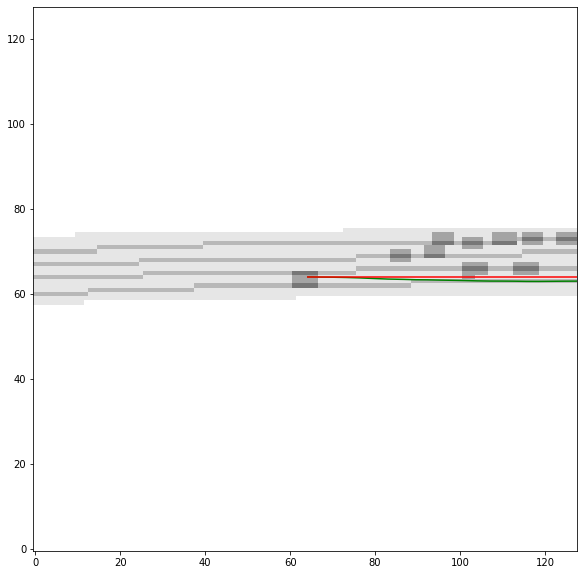

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dataset, dataset_iter, test_dataset, val_dataset
  warnings.warn(message)


In [ ]:
#!c1.8
prediction = model(data_item)

draw_feature_map(
    data_item['prerendered_feature_map'][0],
    data_item['ground_truth_trajectory'][0],
    prediction[0].numpy().astype(np.float32),
    transform=renderer.to_feature_map_tf,
)

Модель справилась довольно неплохо. Посмотрим пример посложнее.

In [ ]:
#!c1.8
for data_item in test_dataset.batch(1):
    # Смещение по оси y больше 5 метров скорее всего будет поворотом, который наша модель предсказать не сможет
    if data_item['ground_truth_trajectory'][0, -1, 1] > 5:
        break

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dataset, dataset_iter, test_dataset, val_dataset
  warnings.warn(message)


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['ground_truth_trajectory', 'scene_id', 'track_id', 'prerendered_feature_map'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


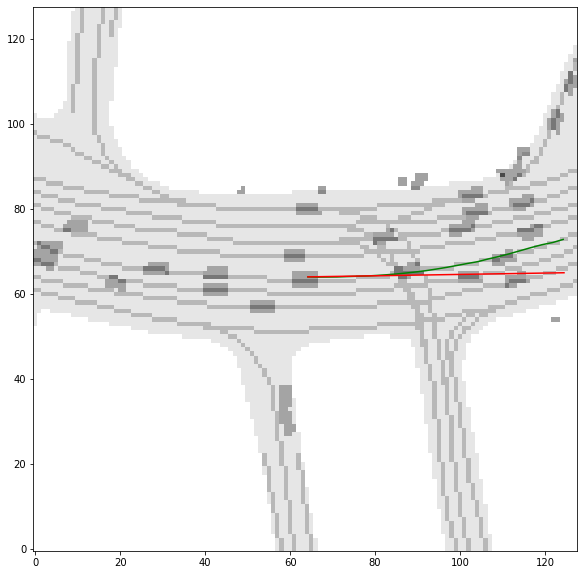

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dataset, dataset_iter, test_dataset, val_dataset
  warnings.warn(message)


In [ ]:
#!c1.8
prediction = model(data_item)

draw_feature_map(
    data_item['prerendered_feature_map'][0],
    data_item['ground_truth_trajectory'][0],
    prediction[0].numpy().astype(np.float32),
    transform=renderer.to_feature_map_tf,
)

## Этап 1

Реализуем нейросеть, которая будет использовать векторное представление и побьёт бейзлайн по метрикам.

Возьмём признаки, которые мы смотрели выше (5 * 8 штук), сделаем Flatten и используем несколько полносвязных слоев. Добавим Dropout и Skip connections.

In [ ]:
#!c1.8

inputs = tf.keras.layers.Input(shape=(5, 8), name='vector_features')
x = tf.keras.layers.Reshape((5, 8))(inputs)
x = tf.keras.layers.Flatten(input_shape=(5, 8))(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
block_1_output = x

x = tf.keras.layers.Dense(100, activation='relu')(block_1_output)
x = tf.keras.layers.Dropout(0.3)(x)
block_2_output = tf.keras.layers.add([x, block_1_output])

x = tf.keras.layers.Dense(100, activation='relu')(block_2_output)
x = tf.keras.layers.Dropout(0.2)(x)
block_3_output = tf.keras.layers.add([x, block_2_output])

x = tf.keras.layers.Dense(100, activation='relu')(block_3_output)
x = tf.keras.layers.Dropout(0.3)(x)
block_4_output = tf.keras.layers.add([x, block_3_output])

x = tf.keras.layers.Dense(100, activation='relu')(block_4_output)
x = tf.keras.layers.Dropout(0.2)(x)
block_5_output = tf.keras.layers.add([x, block_4_output])

x = tf.keras.layers.Dense(100, activation='relu')(block_5_output)
x = tf.keras.layers.Dropout(0.3)(x)
block_6_output = tf.keras.layers.add([x, block_5_output])

x = tf.keras.layers.Dense(100, activation='relu')(block_6_output)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(50)(x)
output = tf.keras.layers.Reshape((25, 2))(x)



dense_model = tf.keras.Model(inputs, output, name="dense_model")

In [ ]:
#!c1.8
dense_model.summary()

Model: "dense_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vector_features (InputLayer)    [(None, 5, 8)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 5, 8)         0           vector_features[0][0]            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 40)           0           reshape[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          4100        flatten[0][0]                    
________________________________________________________________________________________

In [ ]:
#!c1.8
def tf_ade(y_true, y_pred):
    return tf.reduce_mean(tf.norm(y_true - y_pred, axis=-1), axis=-1)
def tf_fde(y_true, y_pred):
    return tf.norm(y_true - y_pred, axis=-1)[..., -1]

In [ ]:
#!c1.8
dense_model.compile(
    optimizer='sgd',
    loss=tf_ade, metrics=[tf_fde])

In [ ]:
#!c1.8
# загрузим данные в векторном представлении
vect_train_x = np.load('vectorizer_train_x.npy')
vect_train_y = np.load('vectorizer_train_y.npy')
vect_test_x = np.load('vectorizer_test_x.npy')
vect_test_y = np.load('vectorizer_test_y.npy')
vect_val_x = np.load('vectorizer_val_x.npy')
vect_val_y = np.load('vectorizer_val_y.npy')

In [ ]:
#!c1.8
dense_model.fit(x=vect_train_x, y=vect_train_y, batch_size=32, epochs=50, verbose=True, use_multiprocessing=True)

Epoch 1/50
4078/4078 [==============================] - 8s 2ms/step - loss: 2.5497 - tf_fde: 5.4014
Epoch 2/50
4078/4078 [==============================] - 7s 2ms/step - loss: 2.2479 - tf_fde: 4.9763
Epoch 3/50
4078/4078 [==============================] - 7s 2ms/step - loss: 2.2064 - tf_fde: 4.9041
Epoch 4/50
4078/4078 [==============================] - 7s 2ms/step - loss: 2.1895 - tf_fde: 4.8700
Epoch 5/50
4078/4078 [==============================] - 7s 2ms/step - loss: 2.1688 - tf_fde: 4.8339
Epoch 6/50
4078/4078 [==============================] - 7s 2ms/step - loss: 2.1482 - tf_fde: 4.7910
Epoch 7/50
4078/4078 [==============================] - 7s 2ms/step - loss: 2.1537 - tf_fde: 4.7980
Epoch 8/50
4078/4078 [==============================] - 7s 2ms/step - loss: 2.1495 - tf_fde: 4.7924
Epoch 9/50
4078/4078 [==============================] - 7s 2ms/step - loss: 2.1413 - tf_fde: 4.7789
Epoch 10/50
4078/4078 [==============================] - 7s 2ms/step - loss: 2.1308 - tf_fde: 4.7566

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dense_model
  warnings.warn(message)


In [ ]:
#!c1.8
pred = dense_model.predict(vect_test_x)
ade_res = round(float(ade(vect_test_y, pred).mean()), 6)
fde_res = round(float(fde(vect_test_y, pred).mean()), 3)
print('Dense_model metrics')
print(f'ADE: {ade_res}, FDE: {fde_res}')

Dense_model metrics
ADE: 2.110274, FDE: 4.409


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dense_model
  warnings.warn(message)


Несмотря на применение dropout и skip connections(продвинутых вещей), модель оказалась хуже бейслайна

А ведь 0 модель была сделана очень просто, давайте сделаем тоже что-то очень примитивное

In [ ]:
#!c1.8
super_dense_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(5, 8), name='vector_features'),
    tf.keras.layers.Reshape((5, 8)),
    tf.keras.layers.Flatten(input_shape=(5, 8)),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(50),
    tf.keras.layers.Reshape((25, 2))
])

In [ ]:
#!c1.8
print(super_dense_model.summary())
super_dense_model.compile(
    optimizer='sgd',
    loss=tf_ade, metrics=[tf_fde])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 5, 8)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              41000     
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_11 (Dense)             (None, 50)                50050     
_________________________________________________________________
reshape_3 (Reshape)          (None, 25, 2)             0

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dense_model
  warnings.warn(message)


In [ ]:
#!c1.8
super_dense_model.fit(x=vect_train_x, y=vect_train_y, batch_size=32, epochs=50, verbose=True, use_multiprocessing=True)

Epoch 1/50
4078/4078 [==============================] - 27s 7ms/step - loss: 2.0570 - tf_fde: 4.6853
Epoch 2/50
4078/4078 [==============================] - 27s 7ms/step - loss: 1.8582 - tf_fde: 4.3005
Epoch 3/50
4078/4078 [==============================] - 27s 7ms/step - loss: 1.8323 - tf_fde: 4.2527
Epoch 4/50
4078/4078 [==============================] - 27s 7ms/step - loss: 1.8129 - tf_fde: 4.2147
Epoch 5/50
4078/4078 [==============================] - 27s 7ms/step - loss: 1.8022 - tf_fde: 4.1932
Epoch 6/50
4078/4078 [==============================] - 27s 7ms/step - loss: 1.7918 - tf_fde: 4.1756
Epoch 7/50
4078/4078 [==============================] - 27s 7ms/step - loss: 1.7779 - tf_fde: 4.1491
Epoch 8/50
4078/4078 [==============================] - 27s 7ms/step - loss: 1.7795 - tf_fde: 4.1485
Epoch 9/50
4078/4078 [==============================] - 27s 7ms/step - loss: 1.7683 - tf_fde: 4.1271
Epoch 10/50
4078/4078 [==============================] - 27s 7ms/step - loss: 1.7614 - tf_f

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dense_model
  warnings.warn(message)


In [ ]:
#!c1.8
pred = super_dense_model.predict(vect_test_x)
ade_res = round(float(ade(vect_test_y, pred).mean()), 6)
fde_res = round(float(fde(vect_test_y, pred).mean()), 3)
print('Simple Dense model metrics')
print(f'ADE: {ade_res}, FDE: {fde_res}')

Dense_model metrics
ADE: 1.404227, FDE: 3.336


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dense_model
  warnings.warn(message)


Baseline побит, причём неплохо, в самой первой модели были дропауты, но они только мешали, ведь самих параметров было не очень много(относительно кол-ва данных)

Поэтому попробуем сделать золотую середину между первой и второй моделью, ну и значительно увеличим кол-во слоёв.

In [ ]:
#!c1.8
inputs = tf.keras.layers.Input(shape=(5, 8), name='vector_features')
x = tf.keras.layers.Reshape((5, 8))(inputs)
x = tf.keras.layers.Flatten(input_shape=(5, 8))(x)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_1_output = x

x = tf.keras.layers.Dense(200, activation='relu')(block_1_output)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_2_output = tf.keras.layers.add([x, block_1_output])

x = tf.keras.layers.Dense(200, activation='relu')(block_2_output)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_3_output = tf.keras.layers.add([x, block_2_output])

x = tf.keras.layers.Dense(200, activation='relu')(block_3_output)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_4_output = tf.keras.layers.add([x, block_3_output])

x = tf.keras.layers.Dense(200, activation='relu')(block_4_output)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_5_output = tf.keras.layers.add([x, block_4_output])

x = tf.keras.layers.Dense(200, activation='relu')(block_5_output)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_6_output = tf.keras.layers.add([x, block_5_output])

x = tf.keras.layers.Dense(200, activation='relu')(block_6_output)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_7_output = tf.keras.layers.add([x, block_6_output])

x = tf.keras.layers.Dense(200, activation='relu')(block_7_output)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_8_output = tf.keras.layers.add([x, block_7_output])

x = tf.keras.layers.Dense(200, activation='relu')(block_8_output)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_9_output = tf.keras.layers.add([x, block_8_output])

x = tf.keras.layers.Dense(200, activation='relu')(block_9_output)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_10_output = tf.keras.layers.add([x, block_9_output])

x = tf.keras.layers.Dense(200, activation='relu')(block_10_output)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_11_output = tf.keras.layers.add([x, block_10_output])

x = tf.keras.layers.Dense(200, activation='relu')(block_11_output)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_12_output = tf.keras.layers.add([x, block_11_output])

x = tf.keras.layers.Dense(200, activation='relu')(block_12_output)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_13_output = tf.keras.layers.add([x, block_12_output])

x = tf.keras.layers.Dense(200, activation='relu')(block_13_output)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_14_output = tf.keras.layers.add([x, block_13_output])

x = tf.keras.layers.Dense(200, activation='relu')(block_14_output)
x = tf.keras.layers.Dense(300, activation='relu')(x)
block_15_output = tf.keras.layers.add([x, block_14_output])

x = tf.keras.layers.Dense(50)(block_15_output)
output = tf.keras.layers.Reshape((25, 2))(x)

deep_model = tf.keras.Model(inputs, output, name="deep_model")

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dense_model
  warnings.warn(message)


In [ ]:
#!c1.8
print(deep_model.summary())
deep_model.compile(
    optimizer='sgd',
    loss=tf_ade, metrics=[tf_fde])

Model: "deep_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vector_features (InputLayer)    [(None, 5, 8)]       0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 5, 8)         0           vector_features[0][0]            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 40)           0           reshape_5[0][0]                  
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 300)          12300       flatten_3[0][0]                  
_________________________________________________________________________________________

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dense_model
  warnings.warn(message)


In [ ]:
#!c1.8
deep_model.fit(x=vect_train_x, y=vect_train_y, batch_size=32, epochs=50, verbose=True, use_multiprocessing=True)

Epoch 1/50
4078/4078 [==============================] - 41s 10ms/step - loss: 2.0314 - tf_fde: 4.5173
Epoch 2/50
4078/4078 [==============================] - 40s 10ms/step - loss: 1.7603 - tf_fde: 4.1161
Epoch 3/50
4078/4078 [==============================] - 41s 10ms/step - loss: 1.7234 - tf_fde: 4.0575
Epoch 4/50
4078/4078 [==============================] - 41s 10ms/step - loss: 1.7029 - tf_fde: 4.0220
Epoch 5/50
4078/4078 [==============================] - 40s 10ms/step - loss: 1.6853 - tf_fde: 3.9911
Epoch 6/50
4078/4078 [==============================] - 40s 10ms/step - loss: 1.6728 - tf_fde: 3.9685
Epoch 7/50
4078/4078 [==============================] - 40s 10ms/step - loss: 1.6637 - tf_fde: 3.9517
Epoch 8/50
4078/4078 [==============================] - 40s 10ms/step - loss: 1.6531 - tf_fde: 3.9322
Epoch 9/50
4078/4078 [==============================] - 40s 10ms/step - loss: 1.6444 - tf_fde: 3.9150
Epoch 10/50
4078/4078 [==============================] - 40s 10ms/step - loss: 1.6

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: deep_model, dense_model
  warnings.warn(message)


In [ ]:
#!c1.8
pred = deep_model.predict(vect_test_x)
ade_res = round(float(ade(vect_test_y, pred).mean()), 6)
fde_res = round(float(fde(vect_test_y, pred).mean()), 3)
print('Deep dense model metrics')
print(f'ADE: {ade_res}, FDE: {fde_res}')

Deep dense model metrics
ADE: 1.287763, FDE: 3.103


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: deep_model, dense_model
  warnings.warn(message)


Эта модель показала себя ещё лучше чем предыдущая.

По итогам первого этапа прояснились достаточно очевидные вещи: не надо использовать dropout, когда в модели немного параметров относительно размера датасета и даже простая полносвязная сеточка лучше такой, но конечно же DEEP LEARNING победило. Благодаря skip connections градиент затухал значительно менее сильно, чем у 2 модели.

## Этап 2

Попробуем улучшить модель из прошлого пункта, добавив изображение.

Для начала можно попробовать использовать только сверточную сеть на картинках. Если этого будет недостаточно можно использовать оба представления.

In [ ]:
#!g1.1
def ade(y_true, y_pred):
    return np.mean(np.linalg.norm(y_true - y_pred, axis=-1), axis=-1)

def fde(y_true, y_pred):
    return np.linalg.norm(y_true - y_pred, axis=-1)[..., -1]

def min_ade(y_true, y_pred):
    y_true = y_true[:, np.newaxis, ...]
    return np.min(ade(y_true, y_pred), axis=1)

def min_fde(y_true, y_pred):
    y_true = y_true[:, np.newaxis, ...]
    return np.min(fde(y_true, y_pred), axis=1)

def tf_ade(y_true, y_pred):
    return tf.reduce_mean(tf.norm(y_true - y_pred, axis=-1), axis=-1)

def tf_fde(y_true, y_pred):
    return tf.norm(y_true - y_pred, axis=-1)[..., -1]


In [ ]:
#!g1.1
vectorizer = FeatureVectorizer(vectorizer_config)
with open('vectorizer_config.yaml') as f:
    vectorizer_config = yaml.safe_load(f)

In [ ]:
#!g1.1
dataset_path = 'data/train'
val_dataset_path = 'data/val'
test_dataset_path = 'data/test'

dataset = TFMotionPredictionDataset(
    # Путь к датасету
    dataset_path=dataset_path,
    # Путь к подготовленным картинкам, у нас они лежат там же
    prerendered_dataset_path=dataset_path,
    # Набор объектов, умеющих готовить фичи для модели. У нас это только векторайзер.
    feature_producers=[vectorizer],
).get_tf_dataset()
train_data = dataset.map(lambda d: ((d['prerendered_feature_map'], d['vector_features']), d['ground_truth_trajectory']))
train_data = train_data.batch(32)

val_dataset = TFMotionPredictionDataset(
    dataset_path=val_dataset_path,
    prerendered_dataset_path=val_dataset_path,
    feature_producers=[vectorizer],
).get_tf_dataset()
val_data = val_dataset.map(lambda d: ((d['prerendered_feature_map'], d['vector_features']), d['ground_truth_trajectory']))
val_data

test_dataset = TFMotionPredictionDataset(
    dataset_path=test_dataset_path,
    prerendered_dataset_path=test_dataset_path,
    feature_producers=[vectorizer],
).get_tf_dataset()

test_data = test_dataset.map(lambda d: ((d['prerendered_feature_map'], d['vector_features']), d['ground_truth_trajectory']))

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: dataset, test_data, test_dataset, train_data, val_data, val_dataset
  warnings.warn(message)


In [ ]:
#!g1.1
inputs = layers.Input(shape=, name="inputs")

x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_3_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_4_output = layers.add([x, block_3_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_4_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_5_output = layers.add([x, block_4_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_5_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_6_output = layers.add([x, block_5_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_6_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_7_output = layers.add([x, block_6_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_7_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_8_output = layers.add([x, block_7_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_8_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_9_output = layers.add([x, block_8_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_9_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_10_output = layers.add([x, block_9_output])

x = layers.Conv2D(64, 3, activation="relu")(block_10_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = tf.keras.Model(inputs, outputs, name="skip_connection_net")
model.summary()

# Полученные результаты

Проведён Research области self-driving cars, в течение которого были найдены подходящие для задачи данные, найдены метрики оценивания моделей, выполняющих задачу, а также протестированы различные подходы Deep Learning, с помощью которых можно решать задачу

В финале получили модель, которая почти очень часто успешно предсказывает траекторию движения автомобиля, но проваливается на краевых случаях